In [1]:
import matplotlib
import rdkit as rd
from rdkit.Chem import AllChem
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import sklearn.metrics as sm
import csv

RDKit WARNING: [14:26:36] Enabling RDKit 2019.09.2 jupyter extensions


In [2]:
# Read in the CDIV molecules
suppl = rd.Chem.SDMolSupplier('../data/raw/ChemDivFull.sdf')

In [3]:
# Extract only the 960 tested molecules
plates = ["CDIV%04d"%p for p in range(1,121,10)]
print(len(plates),plates)
tested = [x for x in suppl if x.GetProp("BATCH_PLATE") in plates]
print(len(suppl),len(tested))

12 ['CDIV0001', 'CDIV0011', 'CDIV0021', 'CDIV0031', 'CDIV0041', 'CDIV0051', 'CDIV0061', 'CDIV0071', 'CDIV0081', 'CDIV0091', 'CDIV0101', 'CDIV0111']
50000 960


In [4]:
# Setup fingerprints for all the molecules 
fp=[]
for m in tested:
    fp.append(AllChem.RDKFingerprint(m, fpSize=2048))
print(fp)

[<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x1a1cf33620>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x1a1cf33670>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x1a1cf33710>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x1a1cf33760>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x1a1cf337b0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x1a1cf33800>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x1a1cf33850>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x1a1cf338a0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x1a1cf338f0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x1a1cf33940>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x1a1cf33990>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x1a1cf339e0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x1a1cf33a30>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect ob

In [5]:
# Set NAME property of molecules to match data from Matlab
for mol in tested:
    if mol is None: continue
    plate=mol.GetProp("BATCH_PLATE")
    plate=int(plate[5:])
    well=mol.GetProp("BATCH_WELL")
    name="%d%s"%(plate,well.replace('0',''))
    print(plate,well,name)
    mol.SetProp("NAME",name)

1 A02 1A2
1 A03 1A3
1 A04 1A4
1 A05 1A5
1 A06 1A6
1 A07 1A7
1 A08 1A8
1 A09 1A9
1 A10 1A1
1 A11 1A11
1 B02 1B2
1 B03 1B3
1 B04 1B4
1 B05 1B5
1 B06 1B6
1 B07 1B7
1 B08 1B8
1 B09 1B9
1 B10 1B1
1 B11 1B11
1 C02 1C2
1 C03 1C3
1 C04 1C4
1 C05 1C5
1 C06 1C6
1 C07 1C7
1 C08 1C8
1 C09 1C9
1 C10 1C1
1 C11 1C11
1 D02 1D2
1 D03 1D3
1 D04 1D4
1 D05 1D5
1 D06 1D6
1 D07 1D7
1 D08 1D8
1 D09 1D9
1 D10 1D1
1 D11 1D11
1 E02 1E2
1 E03 1E3
1 E04 1E4
1 E05 1E5
1 E06 1E6
1 E07 1E7
1 E08 1E8
1 E09 1E9
1 E10 1E1
1 E11 1E11
1 F02 1F2
1 F03 1F3
1 F04 1F4
1 F05 1F5
1 F06 1F6
1 F07 1F7
1 F08 1F8
1 F09 1F9
1 F10 1F1
1 F11 1F11
1 G02 1G2
1 G03 1G3
1 G04 1G4
1 G05 1G5
1 G06 1G6
1 G07 1G7
1 G08 1G8
1 G09 1G9
1 G10 1G1
1 G11 1G11
1 H02 1H2
1 H03 1H3
1 H04 1H4
1 H05 1H5
1 H06 1H6
1 H07 1H7
1 H08 1H8
1 H09 1H9
1 H10 1H1
1 H11 1H11
11 A02 11A2
11 A03 11A3
11 A04 11A4
11 A05 11A5
11 A06 11A6
11 A07 11A7
11 A08 11A8
11 A09 11A9
11 A10 11A1
11 A11 11A11
11 B02 11B2
11 B03 11B3
11 B04 11B4
11 B05 11B5
11 B06 11B6
11 B07 11B7

In [6]:
def getMol(mols,plate,well):
    mol=[x for x in mols if x.GetProp("BATCH_PLATE")=="CDIV%04d"%plate and x.GetProp("BATCH_WELL")==well]
    assert(len(mol)==1)
    return mol[0]

In [17]:
# Set categorization of molecules
# Property, HIT, will be set to true iff we found an aptamer for the molecule
allhits=[]
with open('../data/raw/hasaptamer.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            print(f'\tPlate {row[0]}, well {row[1]} is a hit.')
            line_count += 1
            allhits.append("%s%s"%(row[0],row[1]))
    print(f'Processed {line_count} hits.')
# Set HIT property to true only for hits
for t in tested:
    t.SetBoolProp("HIT",t.GetProp("NAME") in allhits)


Column names are Plate, Well, Fold
	Plate 1, well A4 is a hit.
	Plate 101, well E10 is a hit.
	Plate 101, well E6 is a hit.
	Plate 101, well G6 is a hit.
	Plate 101, well H6 is a hit.
	Plate 31, well D8 is a hit.
	Plate 31, well E3 is a hit.
	Plate 31, well E9 is a hit.
	Plate 41, well D7 is a hit.
	Plate 41, well F3 is a hit.
	Plate 41, well F7 is a hit.
	Plate 41, well H7 is a hit.
	Plate 51, well H8 is a hit.
	Plate 91, well A2 is a hit.
	Plate 91, well A4 is a hit.
	Plate 91, well B2 is a hit.
	Plate 91, well B3 is a hit.
	Plate 91, well C2 is a hit.
	Plate 91, well C3 is a hit.
	Plate 91, well C4 is a hit.
	Plate 91, well D2 is a hit.
	Plate 91, well D3 is a hit.
	Plate 91, well D4 is a hit.
	Plate 91, well E2 is a hit.
	Plate 91, well E4 is a hit.
	Plate 91, well F2 is a hit.
	Plate 91, well F4 is a hit.
	Plate 91, well F5 is a hit.
	Plate 91, well G2 is a hit.
	Plate 91, well G4 is a hit.
	Plate 91, well H2 is a hit.
	Plate 91, well H3 is a hit.
Processed 33 hits.


In [8]:
# Setup ML input as X, output as Y
import numpy as np
X = np.array(list(fp))
y=[t.GetBoolProp("HIT") for t in tested]


In [9]:
# Create train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
print('Fraction hits: train: %.3f, test: %.3f'%(np.mean(y_train),np.mean(y_test)))


Fraction hits: train: 0.036, test: 0.026


In [10]:
clf = RandomForestClassifier(n_estimators=15)
scores = cross_val_score(clf, X, y, cv=5)
np.mean(scores)

0.9760521785620633

In [11]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_predict=rfc.predict(X_test)
y_train_predict=rfc.predict(X_train)

/opt/anaconda3/envs/moldist2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8933155080213904

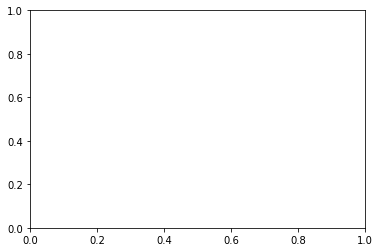

In [12]:
ax = plt.gca()
sm.roc_auc_score(y_test, y_predict)

In [13]:
print(sm.classification_report(y_test, y_predict))
print(sm.confusion_matrix(y_test, y_predict))
print(sm.classification_report(y_train, y_train_predict))
print(sm.confusion_matrix(y_train, y_train_predict))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99       374
        True       0.62      0.80      0.70        10

    accuracy                           0.98       384
   macro avg       0.80      0.89      0.84       384
weighted avg       0.98      0.98      0.98       384

[[369   5]
 [  2   8]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       555
        True       1.00      0.90      0.95        21

    accuracy                           1.00       576
   macro avg       1.00      0.95      0.97       576
weighted avg       1.00      1.00      1.00       576

[[555   0]
 [  2  19]]


In [14]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_predict=lr.predict(X_test)
y_train_predict=lr.predict(X_train)

/opt/anaconda3/envs/moldist2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [15]:
print(sm.classification_report(y_test, y_predict))
print(sm.confusion_matrix(y_test, y_predict))
print(sm.classification_report(y_train, y_train_predict))
print(sm.confusion_matrix(y_train, y_train_predict))

              precision    recall  f1-score   support

       False       1.00      0.98      0.99       374
        True       0.60      0.90      0.72        10

    accuracy                           0.98       384
   macro avg       0.80      0.94      0.86       384
weighted avg       0.99      0.98      0.98       384

[[368   6]
 [  1   9]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       555
        True       1.00      1.00      1.00        21

    accuracy                           1.00       576
   macro avg       1.00      1.00      1.00       576
weighted avg       1.00      1.00      1.00       576

[[555   0]
 [  0  21]]


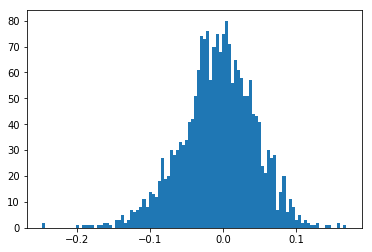

In [16]:
lr.coef_.shape
plt.hist(lr.coef_[0],100)
plt.show()
